In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class AnalysisConfig:
    def __init__(self,
                 shapefile_path='',
                 stations_path='',
                 trip_count_matrix_path=''):
        self.shapefile_path = shapefile_path
        self.stations_path = stations_path
        self.trip_count_matrix_path = trip_count_matrix_path

In [3]:
MATRIX_DIR = '../data/exports/adjacency_matrix'
SHAPEFILE_DIR = '../data/shapefiles/zipcodes'
STATIONS_DIR = '../data/exports'

config_sf = AnalysisConfig(
    shapefile_path = '{}/san_francisco.shp'.format(SHAPEFILE_DIR),
    stations_path = '{}/SF_ele_single station.csv'.format(STATIONS_DIR),
    trip_count_matrix_path = '{}/trip_count_sf.csv'.format(MATRIX_DIR),
)

config_dc = AnalysisConfig(
    shapefile_path = '{}/washington_dc.shp'.format(SHAPEFILE_DIR),
    stations_path = '{}/DC_ele_single station.csv'.format(STATIONS_DIR),
    trip_count_matrix_path = '{}/trip_count_dc.csv'.format(MATRIX_DIR),
)

In [4]:
config = config_sf

In [5]:
def load_gdfs(config):
    zips_gdf = gpd.read_file(config.shapefile_path)
    stations_df = pd.read_csv(config.stations_path)
    stations_gdf = gpd.GeoDataFrame(
        stations_df,
        geometry=gpd.points_from_xy(stations_df['lng'],
                                    stations_df['lat'])).set_crs('EPSG:4326')
    return (zips_gdf, stations_gdf)

In [6]:
trip_matrix = pd.read_csv(config.trip_count_matrix_path).set_index('station_id')
display(trip_matrix)

,SF-M26,SF-M25,SF-M26-2,SF-L27,SF-K26,SF-J27,SF-M30,SF-L27-2,SF-J29-3,SF-J29,...,SF-Z7,SF-Z6,SF-W8,SF-BB17,SF-AA15,SF-Z16,SF-Y14,SF-X14,SF-X19,SF-Y25
station_id,,,,,,,,,,,,,,,,,,,,,
SF-M26,42,3,8,2,4,1,5,4,1,23,...,0,0,0,0,0,0,0,0,0,0
SF-M25,3,44,13,8,30,4,14,1,7,16,...,0,0,0,0,0,1,2,0,1,1
SF-M26-2,9,17,154,26,11,4,7,10,7,82,...,0,0,0,0,1,0,0,0,0,1
SF-L27,0,7,4,59,9,7,32,5,10,85,...,0,0,0,0,0,0,0,0,0,0
SF-K26,9,34,19,7,77,11,17,3,18,46,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SF-Z16,0,0,0,0,0,0,0,0,0,0,...,0,0,2,3,17,19,1,1,2,0
SF-Y14,0,0,0,0,0,0,1,0,0,0,...,2,3,7,0,8,0,89,15,1,0
SF-X14,0,0,0,0,0,0,0,0,0,0,...,1,2,2,2,1,1,5,25,1,2


In [7]:
zips_gdf, stations_gdf, = load_gdfs(config_sf)

In [8]:
def normalize_matrix(matrix):
    return matrix.div(matrix.max().max())
    
trip_matrix_norm = normalize_matrix(trip_matrix)

In [9]:
def get_lat_lng(df, station_id):
    return stations_gdf[stations_gdf['station_id'] == station_id][[
        'lat', 'lng'
    ]].iloc[0][:]

def get_lat_lng_edges(matrix):
    station_ids = list(matrix.columns)
    
    edges = pd.DataFrame([], columns=['lat1', 'lng1', 'lat2', 'lng2', 'value'])
    for id1 in station_ids:
        lat1, lng1 = get_lat_lng(stations_gdf, id1)
        
        for id2 in station_ids:
            if id1 != id2:
                lat2, lng2 = get_lat_lng(stations_gdf, id2)

                edges = edges.append({
                    'lat1': lat1,
                    'lng1': lng1,
                    'lat2': lat2,
                    'lng2': lng2,
                    'value': matrix[id1][id2],
                }, ignore_index=True)
            
    return edges
edges = get_lat_lng_edges(trip_matrix_norm)

In [10]:
sorted_edges = edges[edges['value'] > 0].sort_values(by='value')
sorted_edges['value'] = sorted_edges['value'] / sorted_edges['value'].max()
print(len(sorted_edges))

41583


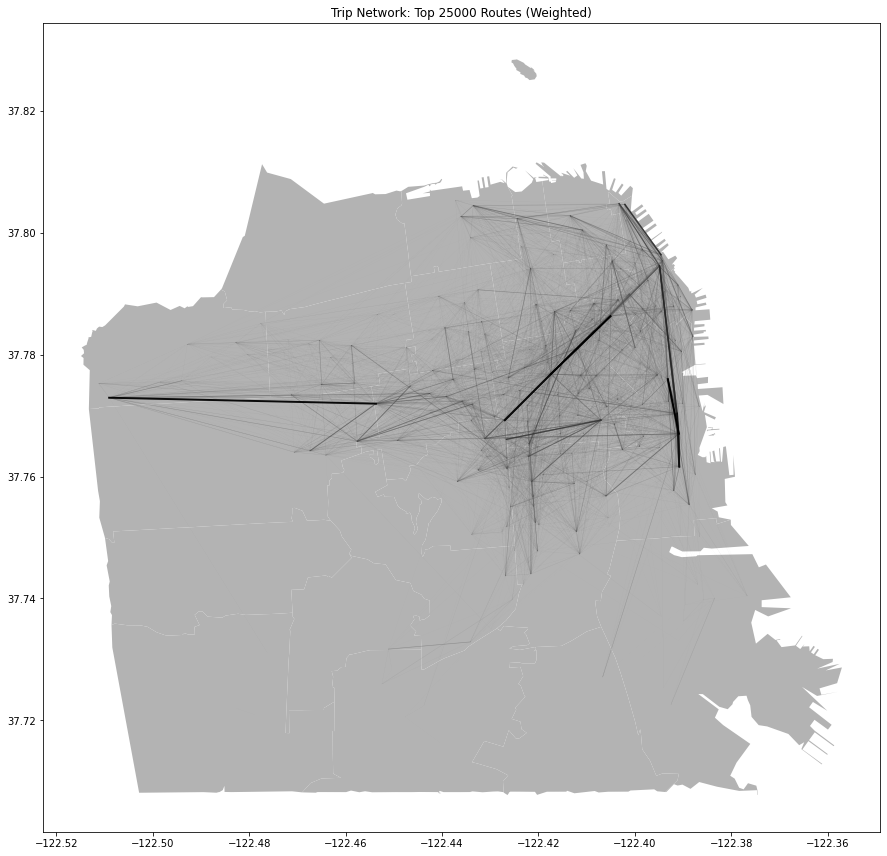

In [11]:
CRS_PLOT = 'EPSG:4326'

def plot_map(fig, ax, zips_gdf):
    zips_gdf.to_crs({'init': CRS_PLOT}).plot(ax=ax, color=str(0.7), zorder=0)
    
def plot_network(fig, ax, stations_gdf, edges, title=''):
    for i, edge in edges.iterrows():
        lat1, lng1, lat2, lng2 = edge[['lat1', 'lng1', 'lat2', 'lng2']]
        # 0.0 = black, 1.0 = white, flip and scale to [0.0, 0.5].
        color = (1 - edge['value']) * 0.5
        alpha = edge['value']
        linewidth = edge['value'] * 2
        ax.plot([lng1, lng2], [lat1, lat2],
                 'k-',
                 linewidth=linewidth,
                 color=str(color),
                 alpha=alpha,
                 zorder=1)

    ax.set_title(title)

N = 25000
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:],
             'Trip Network: Top {} Routes (Weighted)'.format(N))
plt.show()

In [12]:
def get_flow_df(matrix_path):
    matrix = pd.read_csv(matrix_path).set_index('station_id')
    in_counts = matrix.sum(numeric_only=True)
    out_counts = matrix.sum(axis=1)
    matrix['in'] = in_counts
    matrix['out'] = out_counts
    matrix['diff'] = in_counts - out_counts
    return matrix[['in', 'out', 'diff']]

def get_normalized_column(df, column):
    column_min = df[column].min()
    return (df[column] - column_min) / (df[column].max() - column_min)

def normalize_flow_df(df):
    normalized_df = df.copy()
    normalized_df['in'] = get_normalized_column(df, 'in')
    normalized_df['out'] = get_normalized_column(df, 'out')
    normalized_df['diff'] = get_normalized_column(df, 'diff')
    return normalized_df

trip_flow_df = get_flow_df(config.trip_count_matrix_path)

In [13]:
zips_gdf, stations_gdf = load_gdfs(config)
stations_flow_gdf = pd.merge(stations_gdf, trip_flow_df, on='station_id')

def plot_stations(fig, ax, stations_gdf, column, title):
    norm = matplotlib.colors.Normalize()
    stations_gdf.to_crs({
        'init': CRS_PLOT
    }).plot(ax=ax,
            column=column,
            norm=norm,
            legend=True,
            cmap='coolwarm',
            edgecolors='black',
            zorder=2)
    ax.set_title(title)
    return fig, ax

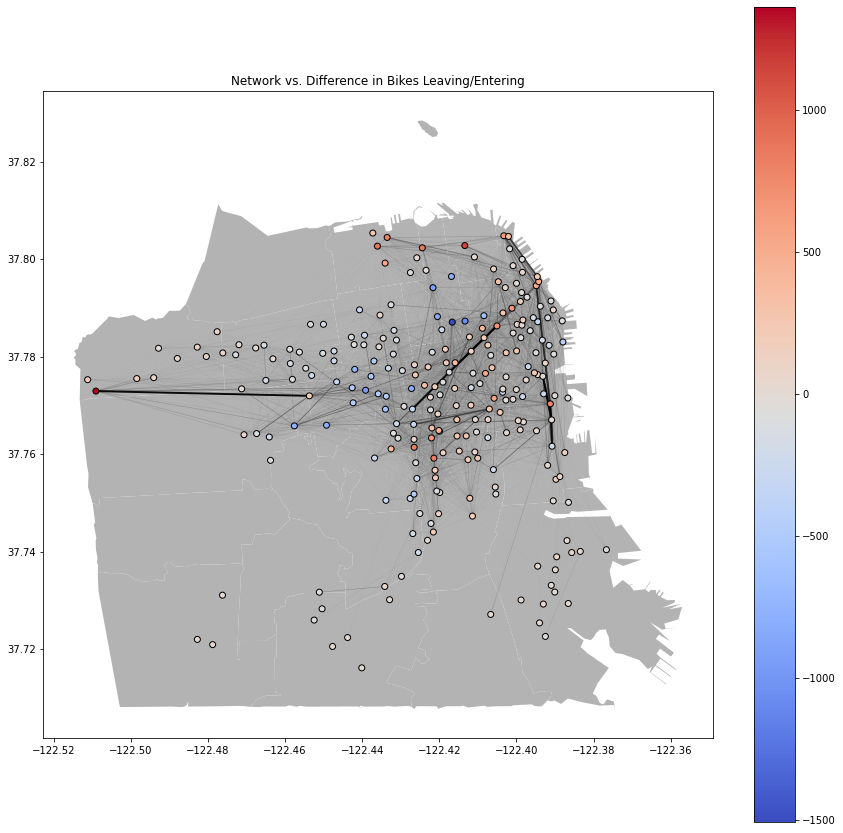

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:])
plot_stations(fig, ax, stations_flow_gdf, 'diff',
              'Network vs. Difference in Bikes Leaving/Entering')
plt.show()

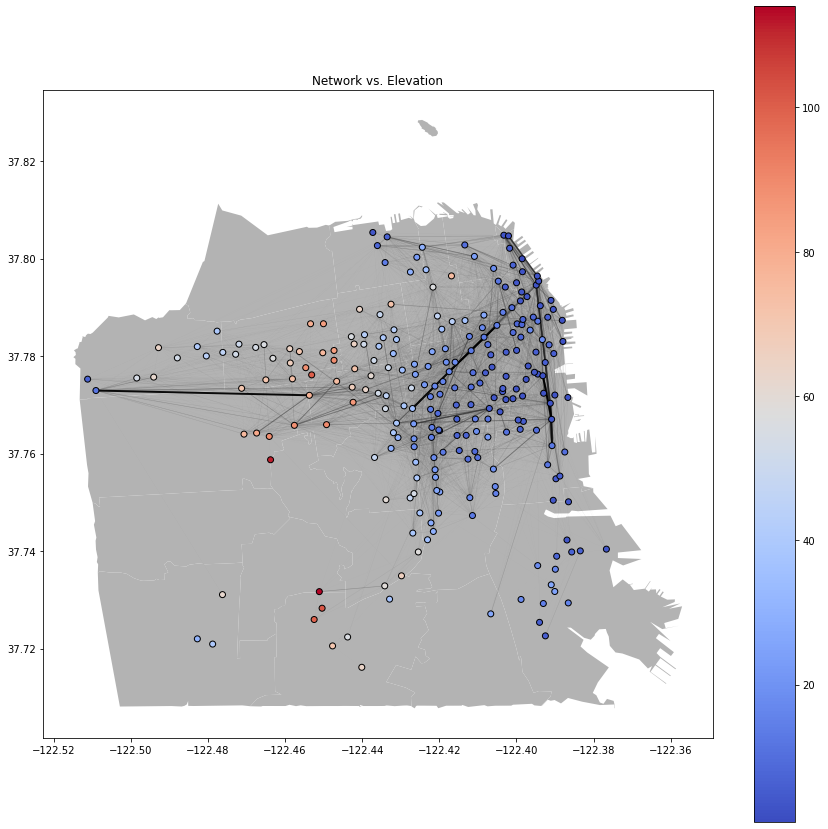

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:])
plot_stations(fig, ax, stations_flow_gdf, 'elevation', 'Network vs. Elevation')
plt.show()